**Segmentation of tomur in Breast ultrasound image Using Residual Block + Attention Block and U_Net Architecture**

**Designer : Aliahmad Rahmani**

In [1]:
# 1. Cennect Google Colab to Google Drive

from google.colab import drive
drive.mount('/content/gdrive') 


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# 2. Prevent disconnection of Google Colb

#function ConnectButton(){ console.log("Connect pushed"); document.querySelector("#top-toolbar > colab-connectbutton").shadowRoot.querySelector("#connect").click() }
#setInterval(ConnectButton,60000);''
 
#Hardware specifications and details

! nvidia-smi


Sat Jul  9 03:50:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# 3. Import Required Modules

import os
import cv2
import glob
import random
import numpy as np
import pandas as pd 
from PIL import Image
import tensorflow as tf
from datetime import datetime 
from keras.metrics import MeanIoU
from matplotlib import pyplot as plt
from keras import backend, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping


In [4]:
# 4. Initialize Images and Masks Size and Read Images and Masks

image_dataset = []  
mask_dataset = []

SIZE = 256 
n_classes= 3 
num_images = 1901

image_names = glob.glob("/content/gdrive/MyDrive/images/*.png")
image_names.sort()
image_names_subset = image_names[0:num_images]
images = [cv2.imread(image, 0) for image in image_names_subset]
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)

mask_names = glob.glob("/content/gdrive/MyDrive/masks/*.png")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)

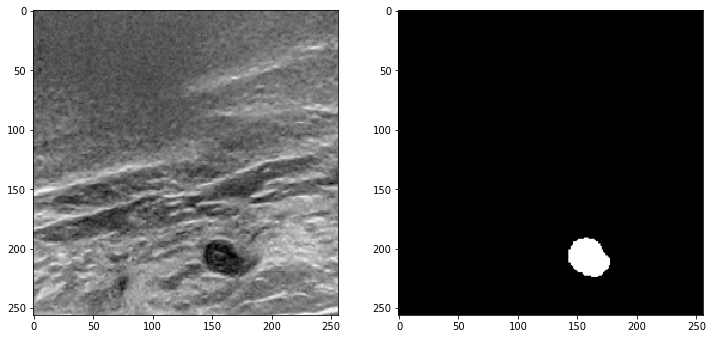

In [5]:
# 5. Checking the matching of images and masks

image_number = random.randint(0, len(image_names_subset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (256, 256)), cmap='gray')
plt.show()

In [6]:
# 6. Checking dataset size and labels

print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (1900, 256, 256, 1)
Mask data shape is:  (1900, 256, 256)
Max pixel value in image is:  255
Labels in the mask are :  [  0 200 255]


In [7]:
# 7. Encode labels to 0, 1, 2

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = mask_dataset.shape  
mask_dataset_reshaped = mask_dataset.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)
mask_dataset_encoded = np.expand_dims(mask_dataset_encoded, axis = 3)
np.unique(mask_dataset_encoded)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2])

In [8]:
# 8. Normalize images ans spliting the dataset into train and test sets

image_dataset = np.array(image_dataset)/255

X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.1, random_state = 42)

In [9]:
# 9. Categorizing the images into 3 classes

train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))
print(y_train_cat.shape)
print(y_test_cat.shape)

(1710, 256, 256, 3)
(190, 256, 256, 3)


In [10]:
# 10. Repeat block

def repeat_elem(tensor, rep):
     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

In [11]:
# 11. Define Residual + Convolutional block

def res_conv_block(x, filter_size, size, dropout = 0.0, batch_norm=True):

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)
    return res_path


In [12]:
# 12. Gating signal layers

def gating_signal(input, out_size, batch_norm=True):

    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

In [13]:
# 13. Define attention block

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn


In [14]:
# 14. Implementation of Residual + Attention + U_Net Model for Semantic Segmentation 

def Attention_ResUNet(input_shape, n_classes=3, dropout_rate=0.0, batch_norm=True):
    
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    axis = 3  # dimension of the image depth

    # input data
    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    
    conv_final = layers.Conv2D(n_classes, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('softmax')(conv_final)

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model

In [15]:
# 15. Parameters for model

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
print(input_shape)

(256, 256, 1)


In [16]:
# 16.Compile Attention Residual Unet
att_res_unet_model = Attention_ResUNet(input_shape)

att_res_unet_model.compile(optimizer=Adam(learning_rate = 3e-4), loss = 'categorical_crossentropy', metrics=['accuracy'])

print(att_res_unet_model.summary())


Model: "AttentionResUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                  

In [17]:
# 17. Train the Model

imageset = 'BUSI_Dataset'
backbone = 'AttRes & U_NET'
version = 'v1.2'
model_h5 = 'model-{imageset}-{backbone}-{version}.h5'.format(imageset=imageset, 
                  backbone = backbone, version = version)
model_h5_checkpoint = '{model_h5}.checkpoint'.format(model_h5=model_h5)

earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint(model_h5_checkpoint, verbose = 1, save_best_only=True)


start = datetime.now() 
att_res_unet_history = att_res_unet_model.fit(X_train, y_train_cat, 
                    verbose=1,
                    batch_size = 8,
                    validation_data=(X_test, y_test_cat ), 
                    shuffle=False,
                    epochs=100,
                    callbacks=[earlystopper, checkpointer])
stop = datetime.now()

#Execution time of the model 
execution_time_AttResUnet = stop-start
print("Attention ResUnet execution time is: ", execution_time_AttResUnet)


Epoch 1/100
214/214 [==============================] - ETA: 0s - loss: 0.8849 - accuracy: 0.8858
Epoch 1: val_loss improved from inf to 1.17863, saving model to model-BUSI_Dataset-AttRes & U_NET-v1.2.h5.checkpoint
INFO:tensorflow:Assets written to: model-BUSI_Dataset-AttRes & U_NET-v1.2.h5.checkpoint/assets
214/214 [==============================] - 251s 1s/step - loss: 0.8849 - accuracy: 0.8858 - val_loss: 1.1786 - val_accuracy: 0.5016
Epoch 2/100
214/214 [==============================] - ETA: 0s - loss: 0.7502 - accuracy: 0.9454
Epoch 2: val_loss improved from 1.17863 to 0.72933, saving model to model-BUSI_Dataset-AttRes & U_NET-v1.2.h5.checkpoint
INFO:tensorflow:Assets written to: model-BUSI_Dataset-AttRes & U_NET-v1.2.h5.checkpoint/assets
214/214 [==============================] - 206s 963ms/step - loss: 0.7502 - accuracy: 0.9454 - val_loss: 0.7293 - val_accuracy: 0.9261
Epoch 3/100
214/214 [==============================] - ETA: 0s - loss: 0.6659 - accuracy: 0.9572
Epoch 3: val_l

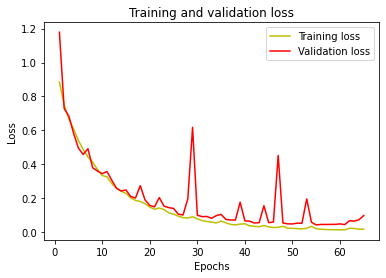

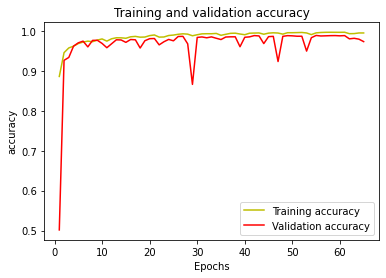

In [18]:
# 18. Check history plots

att_res_unet_history_df = pd.DataFrame(att_res_unet_history.history) 

with open('custom_code_att_res_unet_history_df.csv', mode='w') as f:
    att_res_unet_history_df.to_csv(f)

history = att_res_unet_history

#plot the training and validation accuracy and loss at each epoch

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [19]:
# 19. Load the model for testing.

model = att_res_unet_model
model_path = "/content/model-BUSI_Dataset-AttRes & U_NET-v1.2.h5.checkpoint"

model = tf.keras.models.load_model(model_path, compile=False)

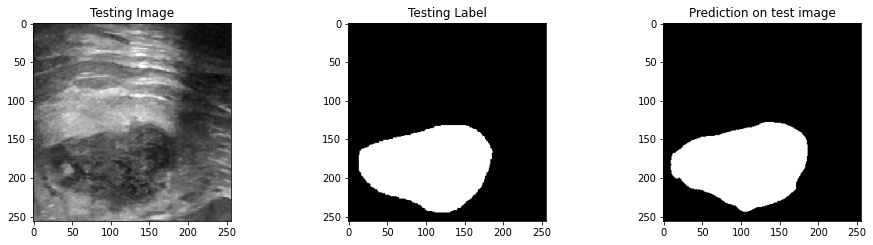

In [22]:
# 20. Display original image, grand truth and predicted image

test_img_number = random.randint(0, X_test.shape[0]-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)*(-1)
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[ :, : , 0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [45]:
# 21. Calculate Multiclass Dice Coef

y_pred=model.predict(X_test) 
y_pred.shape
y_pred_argmax=np.argmax(y_pred, axis=3)

def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, n_classes):
    dice=0
    for index in range(n_classes):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice/n_classes 


def dice_coef_class_1(y_true, y_pred):
    dice_class_1=0
    dice_class_1 = dice_coef(y_true[:,:,:,0], y_pred[:,:,:,0])
    return dice_class_1 


def dice_coef_class_2(y_true, y_pred):
    dice_class_2=0
    dice_class_2 = dice_coef(y_true[:,:,:,1], y_pred[:,:,:,1])
    return dice_class_2


def dice_coef_class_3(y_true, y_pred):
    dice_class_3=0
    dice_class_3 = dice_coef(y_true[:,:,:,2], y_pred[:,:,:,2])
    return dice_class_3 


dice_score = np.round(dice_coef_multilabel(y_test_cat, y_pred, n_classes),4)
print(f'Dice Score is {dice_score}')


class_background_dice_score = np.round(dice_coef_class_1(y_test_cat, y_pred),4)
print(f'Dice Score For Background is {class_background_dice_score}')


class_benign_dice_score = np.round(dice_coef_class_2(y_test_cat, y_pred),4)
print(f'Dice Score For Malignant Tomur is {class_benign_dice_score}')


class_malignant_dice_score = np.round(dice_coef_class_3(y_test_cat, y_pred),4)
print(f'Dice Score For Benign Tomur is {class_malignant_dice_score}')


Dice Score is 0.8927
Dice Score For Background is 0.9894
Dice Score For Malignant Tomur is 0.8414
Dice Score For Benign Tomur is 0.8472


In [29]:
# 22. Define AttResU_NET Model Evaluator (Intersection Over Union _ IOU) Using built in keras function

IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


# Calculate I0U for each class (Background, Benign, Malignant)

values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)

class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[1,0]+ values[2,0]) # Background
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[0,1]+ values[2,1]) # Malignant Tomur
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[0,2]+ values[1,2]) # Benign Tomur

print("IoU For Background is: ", class1_IoU)
print("IoU For Malignant Tomur is: ", class2_IoU)
print("IoU For Benign Tomur is: ", class3_IoU)

Mean IoU = 0.8902411
IoU For Background is:  0.9890955
IoU For Malignant Tomur is:  0.82210904
IoU For Benign Tomur is:  0.8595186
